In [1]:
# General use imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Pre-processing imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize

# Model imports
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

# Performance metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

# Jupyter notebook settings
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = [24, 8]
from IPython.display import display
sns.set_theme(style="darkgrid")

In [2]:
# Helper function definitions
def remove_outliers(df):
    '''
    Remove outliers from dataframe 'df' by bounding feature values within the interquartile range.
    '''
    # Loop through columns in the dataframe, ignoring 'quality' and 'type' columns
    starting_len = len(df)
    for col in df.loc[:, ~df.columns.isin(["quality", "type"])]:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        iqr = Q3 - Q1
        df = df.loc[(df[col] >= Q1 - 2.5 * iqr) & (df[col] <= Q3 + 2.5 * iqr)]
    print(f"Removed: {starting_len - len(df)} outliers")
    return df


def get_feature_importance(Xtrain, model):
    '''
    Return a sorted (high to low) list of feature importances from a given model.
    '''
    # Compute and sort feature importances from the decision tree models
    base_features = [f for f in zip(Xtrain.columns, map(lambda x: np.round(x, 4), model.feature_importances_))]
    base_features = sorted(base_features, key=lambda x: x[1], reverse=True)
    return base_features


def get_confusion_matrix(Xtest, Ytest, model):
    '''
    Compute and return the confusion matrix for the given model.
    '''
    y_pred = model.predict(Xtest)
    cm = confusion_matrix(Ytest, y_pred)
    return cm


def get_F1_avgs(Xtest, Ytest, model):
    '''
    Compute and return macro and weigthed average F1 scores for the given model.
    '''
    y_pred = model.predict(Xtest)
    pm_dict = classification_report(Ytest, y_pred, output_dict=True)
    return pm_dict['macro avg']['f1-score'], pm_dict['weighted avg']['f1-score']


def plot_multiclass_ROC(Xtest, Ytest, model, class_labels, plot_labels, axis):
    '''
    Plot ROC curves for each class from a multiclass classification model.
    Ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Generate predictions from the model
    y_pred = model.predict_proba(Xtest)

    # Convert multi-class test labels to one-vs-all binary
    y_test = label_binarize(Ytest, classes=class_labels)

    # Collect false positive and true positive rates for each class and compute AUC
    fpr, tpr, roc_auc = dict(), dict(), dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curve for each class
    for i, c in zip(range(n_classes), class_labels):
        axis.plot(fpr[i], tpr[i], lw=2, label=f"ROC curve of wine quality {c} (AUC = {roc_auc[i]:.2f}")

    # Set plot limits and labels
    axis.plot([0, 1], [0, 1], 'k--', lw=2)
    axis.set_xlim([-0.05, 1.0]); axis.set_ylim([0.0, 1.05])
    axis.set_xlabel('False Positive Rate'); axis.set_ylabel('True Positive Rate')
    axis.set_title(f"[{plot_labels[0]} WINE] ROC curves for {plot_labels[1]} Classifier", fontsize=20) 
    axis.legend(loc="lower right")

<figure>
  <IMG SRC="https://www.colorado.edu/cs/profiles/express/themes/cuspirit/logo.png" WIDTH=40 ALIGN="right">
</figure>

# Predicting wine quality with supervised learning algorithms
*CSPB 4830 Machine Learning - Summer 2022*

* Author: Thomas Cochran

* Github: https://github.com/t-cochran/CSPB_4830_supervised_learning_project

__Project Description__

* The goal of this project is to classify wine quality using physiochemical properties, e.g. pH, sulphates, sugar, and alcohol content.

* Different supervised learning algorithms will be trained to accomplish this task. Their performance will be compared and evaluated.

__Problem Type__

* This is an multiclass classification problem. The target class `quality` is an ordinal variable that ranks wine quality on a scale from $[0, 10]$.

__Project Motivation__

* Data driven approaches can assist wine producers to quickly and objectively assess wine quality at various stages of production.

* Identifying features most critical to wine quality can assist commercial producers in optimizing growing conditions and harvest.

* Consumers can make more informed decisions by recognizing features associated with higher quality wines.


## Dataset Information

__Dataset Source__

* The dataset is from the UC Irvine (UCI) Machine Learning Repository ([source](https://archive.ics.uci.edu/ml/datasets/wine+quality)).

* It was donated to the UCI repository from the University of Minho, Portugal where it was wrangled for the purposes of this publication:

> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Cortez, P., Cerdeira, A., Almeida, F., Matos, T., &amp; Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Decision Support Systems, 47(4), 547–553. https://doi.org/10.1016/j.dss.2009.05.016 

* The type of wine in this dataset is *vinho verde* from the Minho region of portugal, which accounts for 15% of Portugese wine production.

    * Data was collected between May 2004 to February 2007 by routine laboratory physiochemical tests and human expert tasters.
    
    * The primary reason for collecting these data on the wine was to certify the wine as a protected designated origin.

__Dataset Size and Features__

* Rows in this dataset correspond to a single wine sample and columns correspond to the recorded features for each sample.

* Here is a summary of the dataset's contents:

    * Two separate datasets: one for white wine and one for red wine. Both datasets have the same set of features.

    * 4897 rows for white wine, 1598 rows for red wine

    * 12 feature columns

    * 340 KB size

* Most features are continuous numeric concentrations of a compounds within the wine. These features and their units are:

<style>
td {
  text-align: center;
  vertical-align: middle;
}
</style>
<table align="center">
  <tr> <th>feature</th> <th>units</th> </tr>
  <tr> <td>fixed acidity</td><td>g/L</td> </tr>
  <tr> <td>volatile acidity</td><td>g/L</td> </tr>
  <tr> <td>citric acid</td><td>g/L</td> </tr>
  <tr> <td>residual sugar </td><td>g/L</td> </tr>
  <tr> <td>chlorides </td><td>g/L</td> </tr>
  <tr> <td>free sulfur dioxide</td><td>mg/L</td> </tr>
  <tr> <td>total sulfur dioxide</td><td>mg/L</td> </tr>
  <tr> <td>density </td><td>g/L</td> </tr>
  <tr> <td>pH</td><td>[0, 14]</td></tr>
  <tr> <td>sulphates</td><td>g/L</td> </tr>
  <tr> <td>alcohol</td><td>vol %</td> </tr>
  <tr> <td>quality</td><td>[0, 10]</td> </tr>
</table>
<br>

* The target feature is `quality` which is an ordinal variable between 0 and 10 with 0 being poorest quality and 10 being highest quality. 

* Wine quality was classified by human experts involved in the process of certifying the wine as a product of protected designated origin.

__Loading the datasets__

* Next I will load both datasets (one for white wine, one for red wine) into dataframes and designate the independent and dependent variables.

In [4]:
# Load the red and white wine datasets into dataframes
df_white = pd.read_csv('dataset/winequality-white.csv', sep=';', dtype='unicode')
df_red = pd.read_csv('dataset/winequality-red.csv', sep=';', dtype='unicode')

# Create new columns to designate red wine and white wine and then stack dataframes into a single dataframe
df_white["type"] = "White"; df_red["type"] = "Red"
df = pd.concat([df_white, df_red], ignore_index=True, axis=0)

# Display the first three rows for each dataset
print("White Wine Dataset:"); display(df[df["type"] == "White"].head(n=3))
print("Red Wine Dataset:"); display(df[df["type"] == "Red"].head(n=3))

White Wine Dataset:


fixed acidity volatile acidity citric acid residual sugar chlorides  \
0             7             0.27        0.36           20.7     0.045   
1           6.3              0.3        0.34            1.6     0.049   
2           8.1             0.28         0.4            6.9      0.05   

  free sulfur dioxide total sulfur dioxide density    pH sulphates alcohol  \
0                  45                  170   1.001     3      0.45     8.8   
1                  14                  132   0.994   3.3      0.49     9.5   
2                  30                   97  0.9951  3.26      0.44    10.1   

  quality   type  
0       6  White  
1       6  White  
2       6  White

Red Wine Dataset:


fixed acidity volatile acidity citric acid residual sugar chlorides  \
4898           7.4              0.7           0            1.9     0.076   
4899           7.8             0.88           0            2.6     0.098   
4900           7.8             0.76        0.04            2.3     0.092   

     free sulfur dioxide total sulfur dioxide density    pH sulphates alcohol  \
4898                  11                   34  0.9978  3.51      0.56     9.4   
4899                  25                   67  0.9968   3.2      0.68     9.8   
4900                  15                   54   0.997  3.26      0.65     9.8   

     quality type  
4898       5  Red  
4899       5  Red  
4900       5  Red

## Data cleaning:

* Since the dataset was used in a peer reviewed journal publication before being donated, much of the wrangling and cleaning has been done. 

* I will still double check for missing values, cast data into appropriate types, and check for outliers.

__Check for missing values__

In [5]:
# Sum NaN values in all columns
missing_vals = df.isnull().sum()
print(f"Total missing values in dataset: {missing_vals.sum()}")

Total missing values in dataset: 0


__Cast data types__

* The data types for each feature are listed as `object` which means they are encoded as a string of varying length.

In [6]:
# Check the current datatypes of each feature
display(df.dtypes)

fixed acidity           object
volatile acidity        object
citric acid             object
residual sugar          object
chlorides               object
free sulfur dioxide     object
total sulfur dioxide    object
density                 object
pH                      object
sulphates               object
alcohol                 object
quality                 object
type                    object
dtype: object

* Since most features are concentraions of different chemical compounds, they are continuous numeric features that will be cast as type `float`.

* The ordinal target class `quality` will be an integer between 0 and 10, and the categorical feature `type` will remain a string.

In [7]:
# Loop through columns and cast to appropriate datatypes
for col in df:
    if col == "quality":
        df[col] = df[col].astype(int)
    elif col == "type":
        df[col] = df[col].astype(str)
    else:
        df[col] = df[col].astype(float)

# Check the new datatypes for each feature
display(df.dtypes)

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int32
type                     object
dtype: object

__Detect and remove outliers__ 

* It's common to remove features with values 1.5x beyond the feature interquartile range. However, I expect some wines to have a rather high variance for certain features (such as sugar content or alcohol content) and I do not want to lose too many of these samples.

* As a more conservative approach, I will remove features whose values are 2.5x beyond the feature interquartile range. These outlier features correspond to approximately $4\sigma$ beyond their mean value, which is quite conservative.

In [8]:
# Remove outliers in each dataset and sort by quality
df = remove_outliers(df).sort_values(["quality"], ascending=True)

Removed: 495 outliers


## Exploratory Data Analysis (EDA):

__Target class distributions__

* The distribution of wine quality should follow a normal distribution because most wines should be good, with few being excellent or poor. This means there should be a large class imbalance in wine quality (our target class) which must be addressed prior to training.

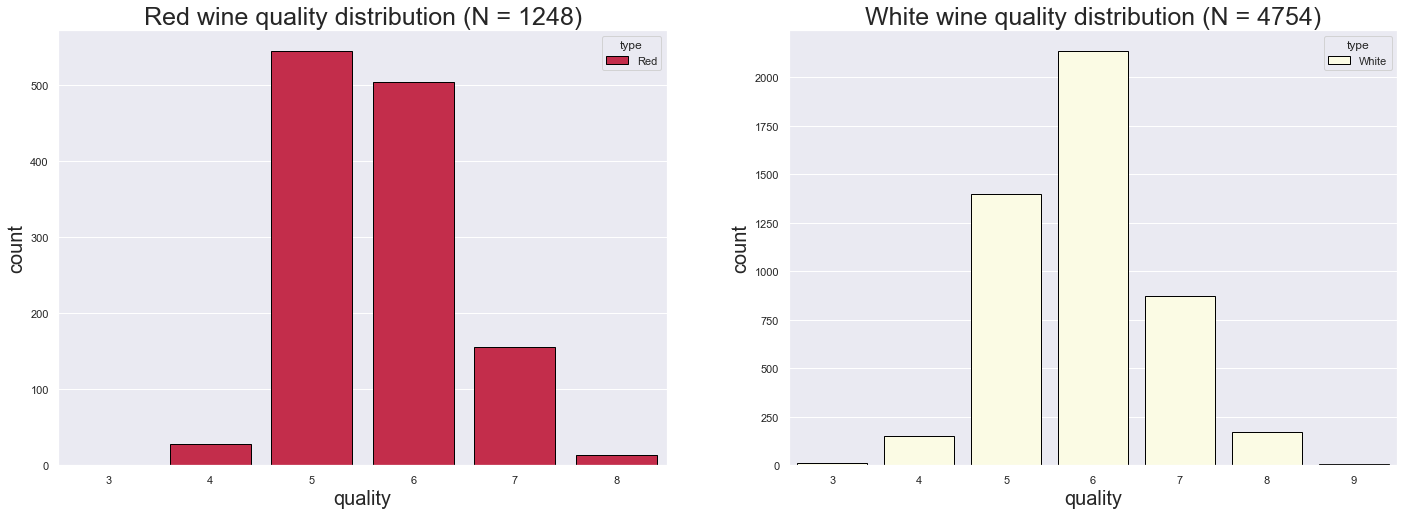

In [9]:
# Plot the distribution of wine quality for red and white wines
fig, axes = plt.subplots(ncols=2)
for wine_type, ax in zip(["Red", "White"], axes):
    n = len(df[df["type"] == wine_type])
    sns.countplot(x="quality", data=df[df["type"] == wine_type], ax=ax, hue='type', 
                  palette={"White": "lightyellow", "Red": "crimson"}, edgecolor='black')
    ax.set_title(f"{wine_type} wine quality distribution (N = {n})", fontsize=25)
    ax.set_xlabel("quality", fontsize = 20); ax.set_ylabel("count", fontsize = 20)

* A target class imbalance does exist at the tail ends of quality, i.e. at poor quality [0 - 4] and excellent quality [7 - 9]. Unfortunately, the sample size for some of these very poor or very good values is far too low and would be difficult to balance with oversampling techniques:

In [10]:
# Print the number of values in each wine quality ranking
print(df["quality"].value_counts())

6    2640
5    1946
7    1031
8     185
4     181
3      14
9       5
Name: quality, dtype: int64


* Since the sample size for `quality=9` and `quality=3` wines may be prohibitively low to balance, I will exclude these samples:

In [11]:
# Remove quality=3 (very poor) and quality=9 (very good) wines due to their very low sample size
df = df[(df["quality"] > 3) & (df["quality"] < 9)]
print(df["quality"].value_counts())

6    2640
5    1946
7    1031
8     185
4     181
Name: quality, dtype: int64


__Feature descriptive statistics__

* Investigate some descriptive statistics for each feature to get a handle on the range and spread of their values.

In [12]:
# Create a dataframe for red and white wine for easy access during EDA
red_df = df[df["type"] == "Red"].loc[:, ~df.columns.isin(["type"])]
white_df = df[df["type"] == "White"].loc[:, ~df.columns.isin(["type"])]

# Generate descriptive statistics for numeric features in both red wine and white wine datasets
df.loc[:, ~df.columns.isin(["type"])].describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    5983.000000       5983.000000  5983.000000     5983.000000   
mean        7.074102          0.325053     0.311519        5.574787   
std         1.034317          0.144899     0.131981        4.728872   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.220000     0.250000        1.800000   
50%         6.900000          0.280000     0.310000        3.300000   
75%         7.600000          0.390000     0.380000        8.300000   
max        10.900000          0.825000     0.740000       23.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  5983.000000          5983.000000           5983.000000  5983.000000   
mean      0.050599            31.017048            118.814641     0.994501   
std       0.019003            16.705531             54.486028     0.002877   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.037000            18.000000             85.000000     0.992145   
50%       0.046000            29.000000            121.000000     0.994660   
75%       0.058000            42.000000            157.000000     0.996780   
max       0.118000           101.000000            303.000000     1.002600   

                pH    sulphates      alcohol      quality  
count  5983.000000  5983.000000  5983.000000  5983.000000  
mean      3.220012     0.519572    10.512708     5.848404  
std       0.158551     0.128018     1.199628     0.848180  
min       2.720000     0.220000     8.000000     4.000000  
25%       3.110000     0.430000     9.500000     5.000000  
50%       3.210000     0.500000    10.400000     6.000000  
75%       3.320000     0.590000    11.316667     6.000000  
max       3.820000     0.980000    14.200000     8.000000

* The mean of most features are within the interval $[0.0, 20.0]$, with the exception of sulfur dioxide concentrations which are larger values since these features were recorded in units mg/L instead of g/L.

__Feature value boxplots__

* Visualize the spread of values around the mean of each feature for red and white wines by creating boxplots.

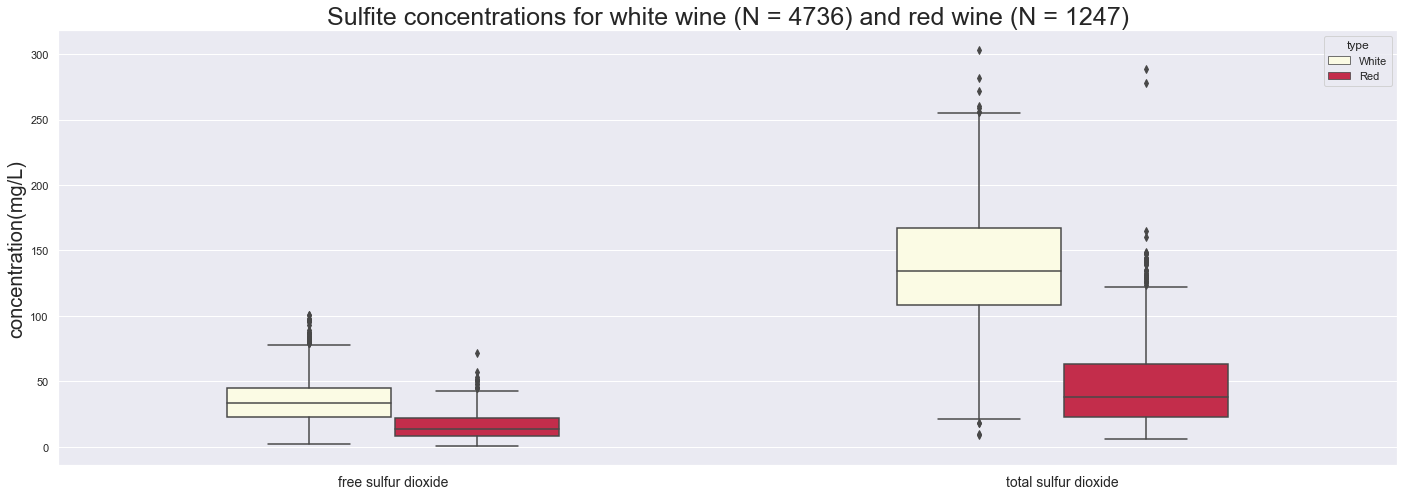

In [13]:
# Select sulfite concentrations for red and white wine
sulfite_df = df[["free sulfur dioxide", "total sulfur dioxide", "type"]]
mdf = pd.melt(sulfite_df, id_vars=["type"])

# Create boxplots of red and white wine sulfite concentrations
sulfite_boxplot = sns.boxplot(x="variable", y="value", 
                              hue="type", data=mdf, width=0.5, 
                              palette={"White": "lightyellow", "Red": "crimson"})

# Boxplot settings
X_white = white_df.loc[:, ~white_df.columns.isin(["quality"])]
X_red = red_df.loc[:, ~red_df.columns.isin(["quality"])]
sulfite_boxplot.set_title(f"Sulfite concentrations for white wine (N = {len(X_white)}) and red wine (N = {len(X_red)})", fontsize=25)
sulfite_boxplot.set_xlabel("", fontsize = 20); sulfite_boxplot.set_ylabel("concentration(mg/L)", fontsize = 20)
sulfite_boxplot.set_xticklabels(sulfite_boxplot.get_xticklabels(),rotation=0,fontdict={'fontsize':14});


* The boxplots indicate white wine could have a larger mean sulfur dioxide (i.e. sulfite) concentration than red wine, though it is difficult to test whether this is statistically significant due to the larger variance in the red wine dataset, and its much smaller sample size.

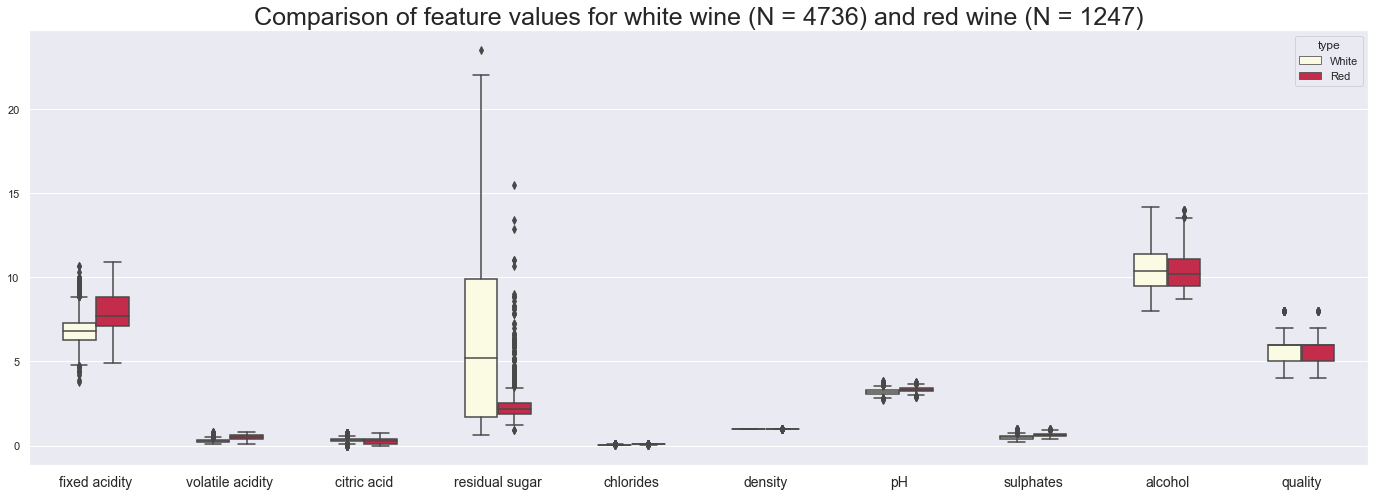

In [14]:
# Select features other than sulfite concentrations for red and white wine
non_sulfite_df = df.loc[:, ~df.columns.isin(["free sulfur dioxide", "total sulfur dioxide"])]
mdf = pd.melt(non_sulfite_df, id_vars=["type"])

# Create boxplots of red and white wine sulfite concentrations
sulfite_boxplot = sns.boxplot(x="variable", y="value", 
                              hue="type", data=mdf, width=0.5, 
                              palette={"White": "lightyellow", "Red": "crimson"})

# Boxplot settings
X_white = white_df.loc[:, ~white_df.columns.isin(["quality"])]
X_red = red_df.loc[:, ~red_df.columns.isin(["quality"])]
sulfite_boxplot.set_title(f"Comparison of feature values for white wine (N = {len(X_white)}) and red wine (N = {len(X_red)})", fontsize=25)
sulfite_boxplot.set_xlabel("", fontsize = 20); sulfite_boxplot.set_ylabel("", fontsize = 20)
sulfite_boxplot.set_xticklabels(sulfite_boxplot.get_xticklabels(),rotation=0,fontdict={'fontsize':14});

* The `residual sugar` content has a larger mean value in white wine, but this feature may be unreliable due to its large interquartile range.

__Feature correlation heatmaps__

* Check the correlation between pairs of features for both red and white wines by creating correlation heatmaps.

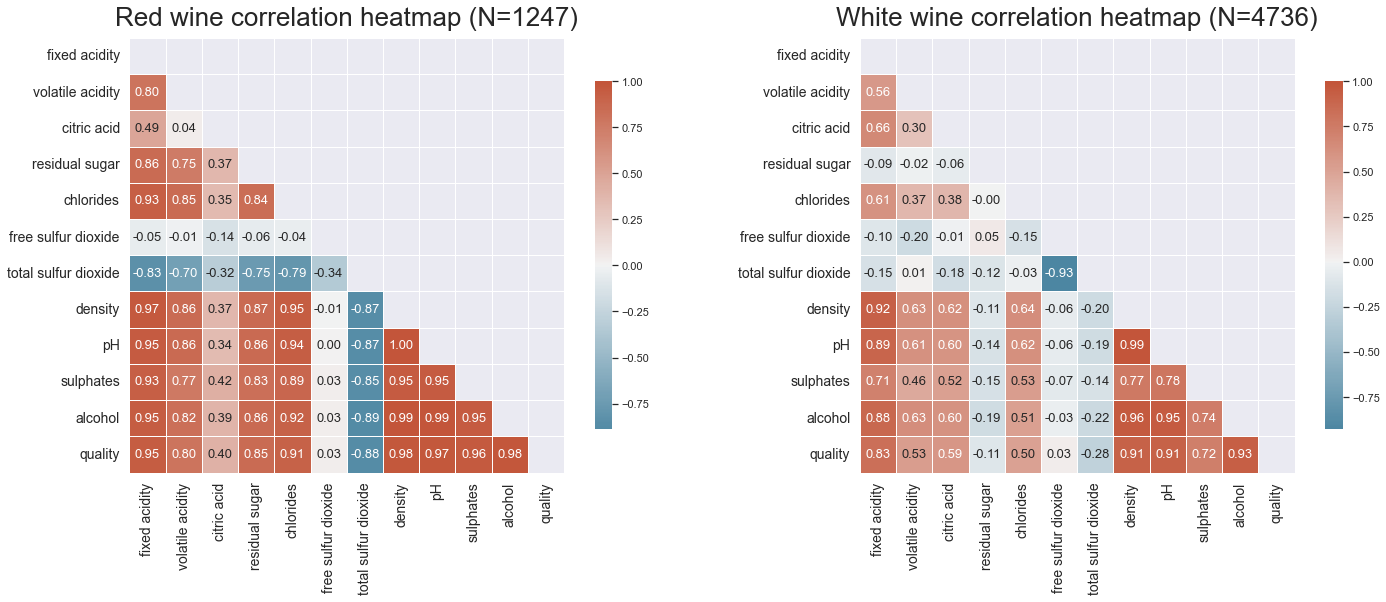

In [15]:
fig, axes = plt.subplots(ncols=2)
for t, f, ax in zip(["Red wine", "White wine"], [red_df, white_df], axes):
    # Normalize and then compute a pairwise correlation of numeric columns
    normalized_pd = pd.DataFrame(Normalizer().fit_transform(f), columns=f.columns)
    corr = normalized_pd.corr('spearman')

    # Mask the upper triangle of the heatmap and create a diverging colormap
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Create the heatmap
    corr_heatmap = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0, square=True, 
                               linewidths=.5, cbar_kws={"shrink": .80}, annot=True, 
                               annot_kws={"fontsize":13}, fmt='.2f', ax=ax)

    # Heatmap settings
    corr_heatmap.set_title(f"{t} correlation heatmap (N={len(normalized_pd)})", fontdict={'fontsize':26}, pad=12);
    corr_heatmap.set_xticklabels(corr_heatmap.get_xticklabels(), size=14)
    corr_heatmap.set_yticklabels(corr_heatmap.get_yticklabels(), size=14);

* Red wine total sulfur dioxide is highly negatively correlated ($ρ = -0.88$) with quality. This occurs to a lesser degree in white wines.

* Density, pH, and alcohol content are highly positively correlated ($ρ > 0.90$) with quality in both red wines and white wines.

__Alcohol content vs total sulfur dioxide__

* There is a large positive correlation between alcohol content and quality ($ρ >= 0.93$) for both red wine and white wine. There is also a moderate to large negative correlation between alcohol content and quality ($ρ <= -0.28$ for white wine; $ρ <= -0.88$ for red wine). 

* I will drill down on these strong feature relationships by creating a scatterplot of mean alcohol content versus sulfur dioxide content.

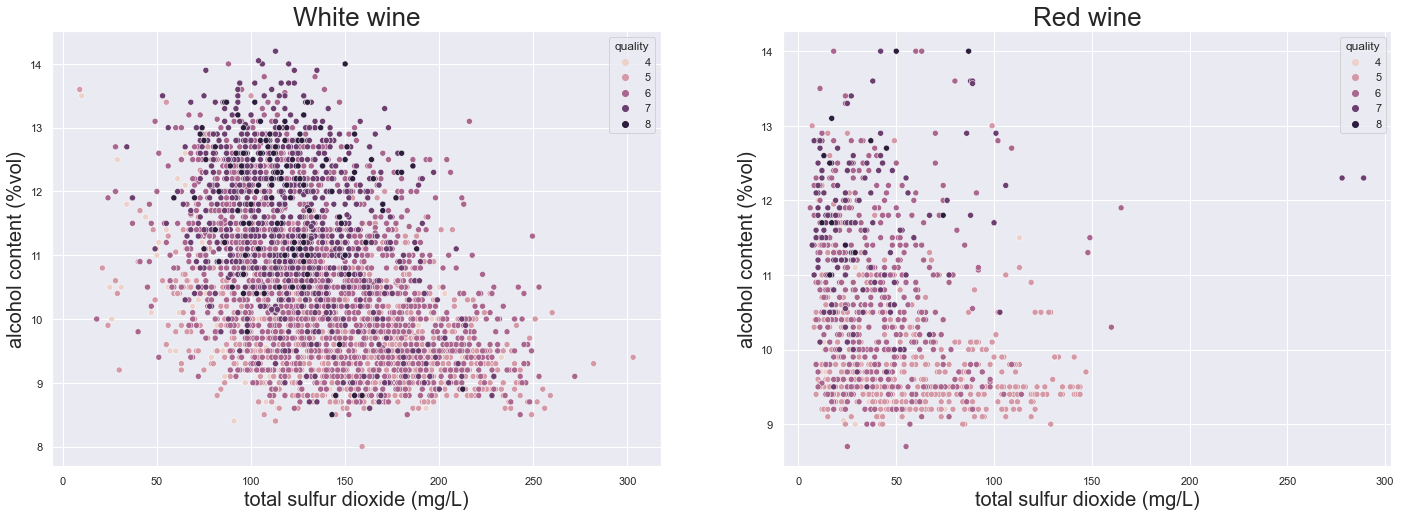

In [16]:
# Create scatter plots of alcohol content vs total sulfur dioxide for red and white wine datasets
fix, axes = plt.subplots(ncols=2)
for t, ax in zip(["White", "Red"], axes):
    sns.scatterplot(x="total sulfur dioxide", y="alcohol", hue="quality", data=df[df["type"] == t], ax=ax)
    ax.set_title(f"{t} wine", fontdict={'fontsize':26})
    ax.set_xlabel("total sulfur dioxide (mg/L)", fontdict={'fontsize':20})
    ax.set_ylabel("alcohol content (%vol)", fontdict={'fontsize':20})
    ax.legend(title="quality", loc='upper right');

* Higher quality wines may cluster around certain ranges of total sulfur dioxide and this range appears to be lower for red wines than white.

* Higher quality wines may cluster at higher alcohol content levels, however this is less visible in red wine due to the lower sample sizes.

__Kernel density estimate (KDE) pairplots__

* The next set of plots will investigate pairwise relationships between features by plotting KDE plots for each feature pairing.

* KDE plots will have their hue set to the target class `quality` so we can visualize densities with higher quality accross different feature pairings.

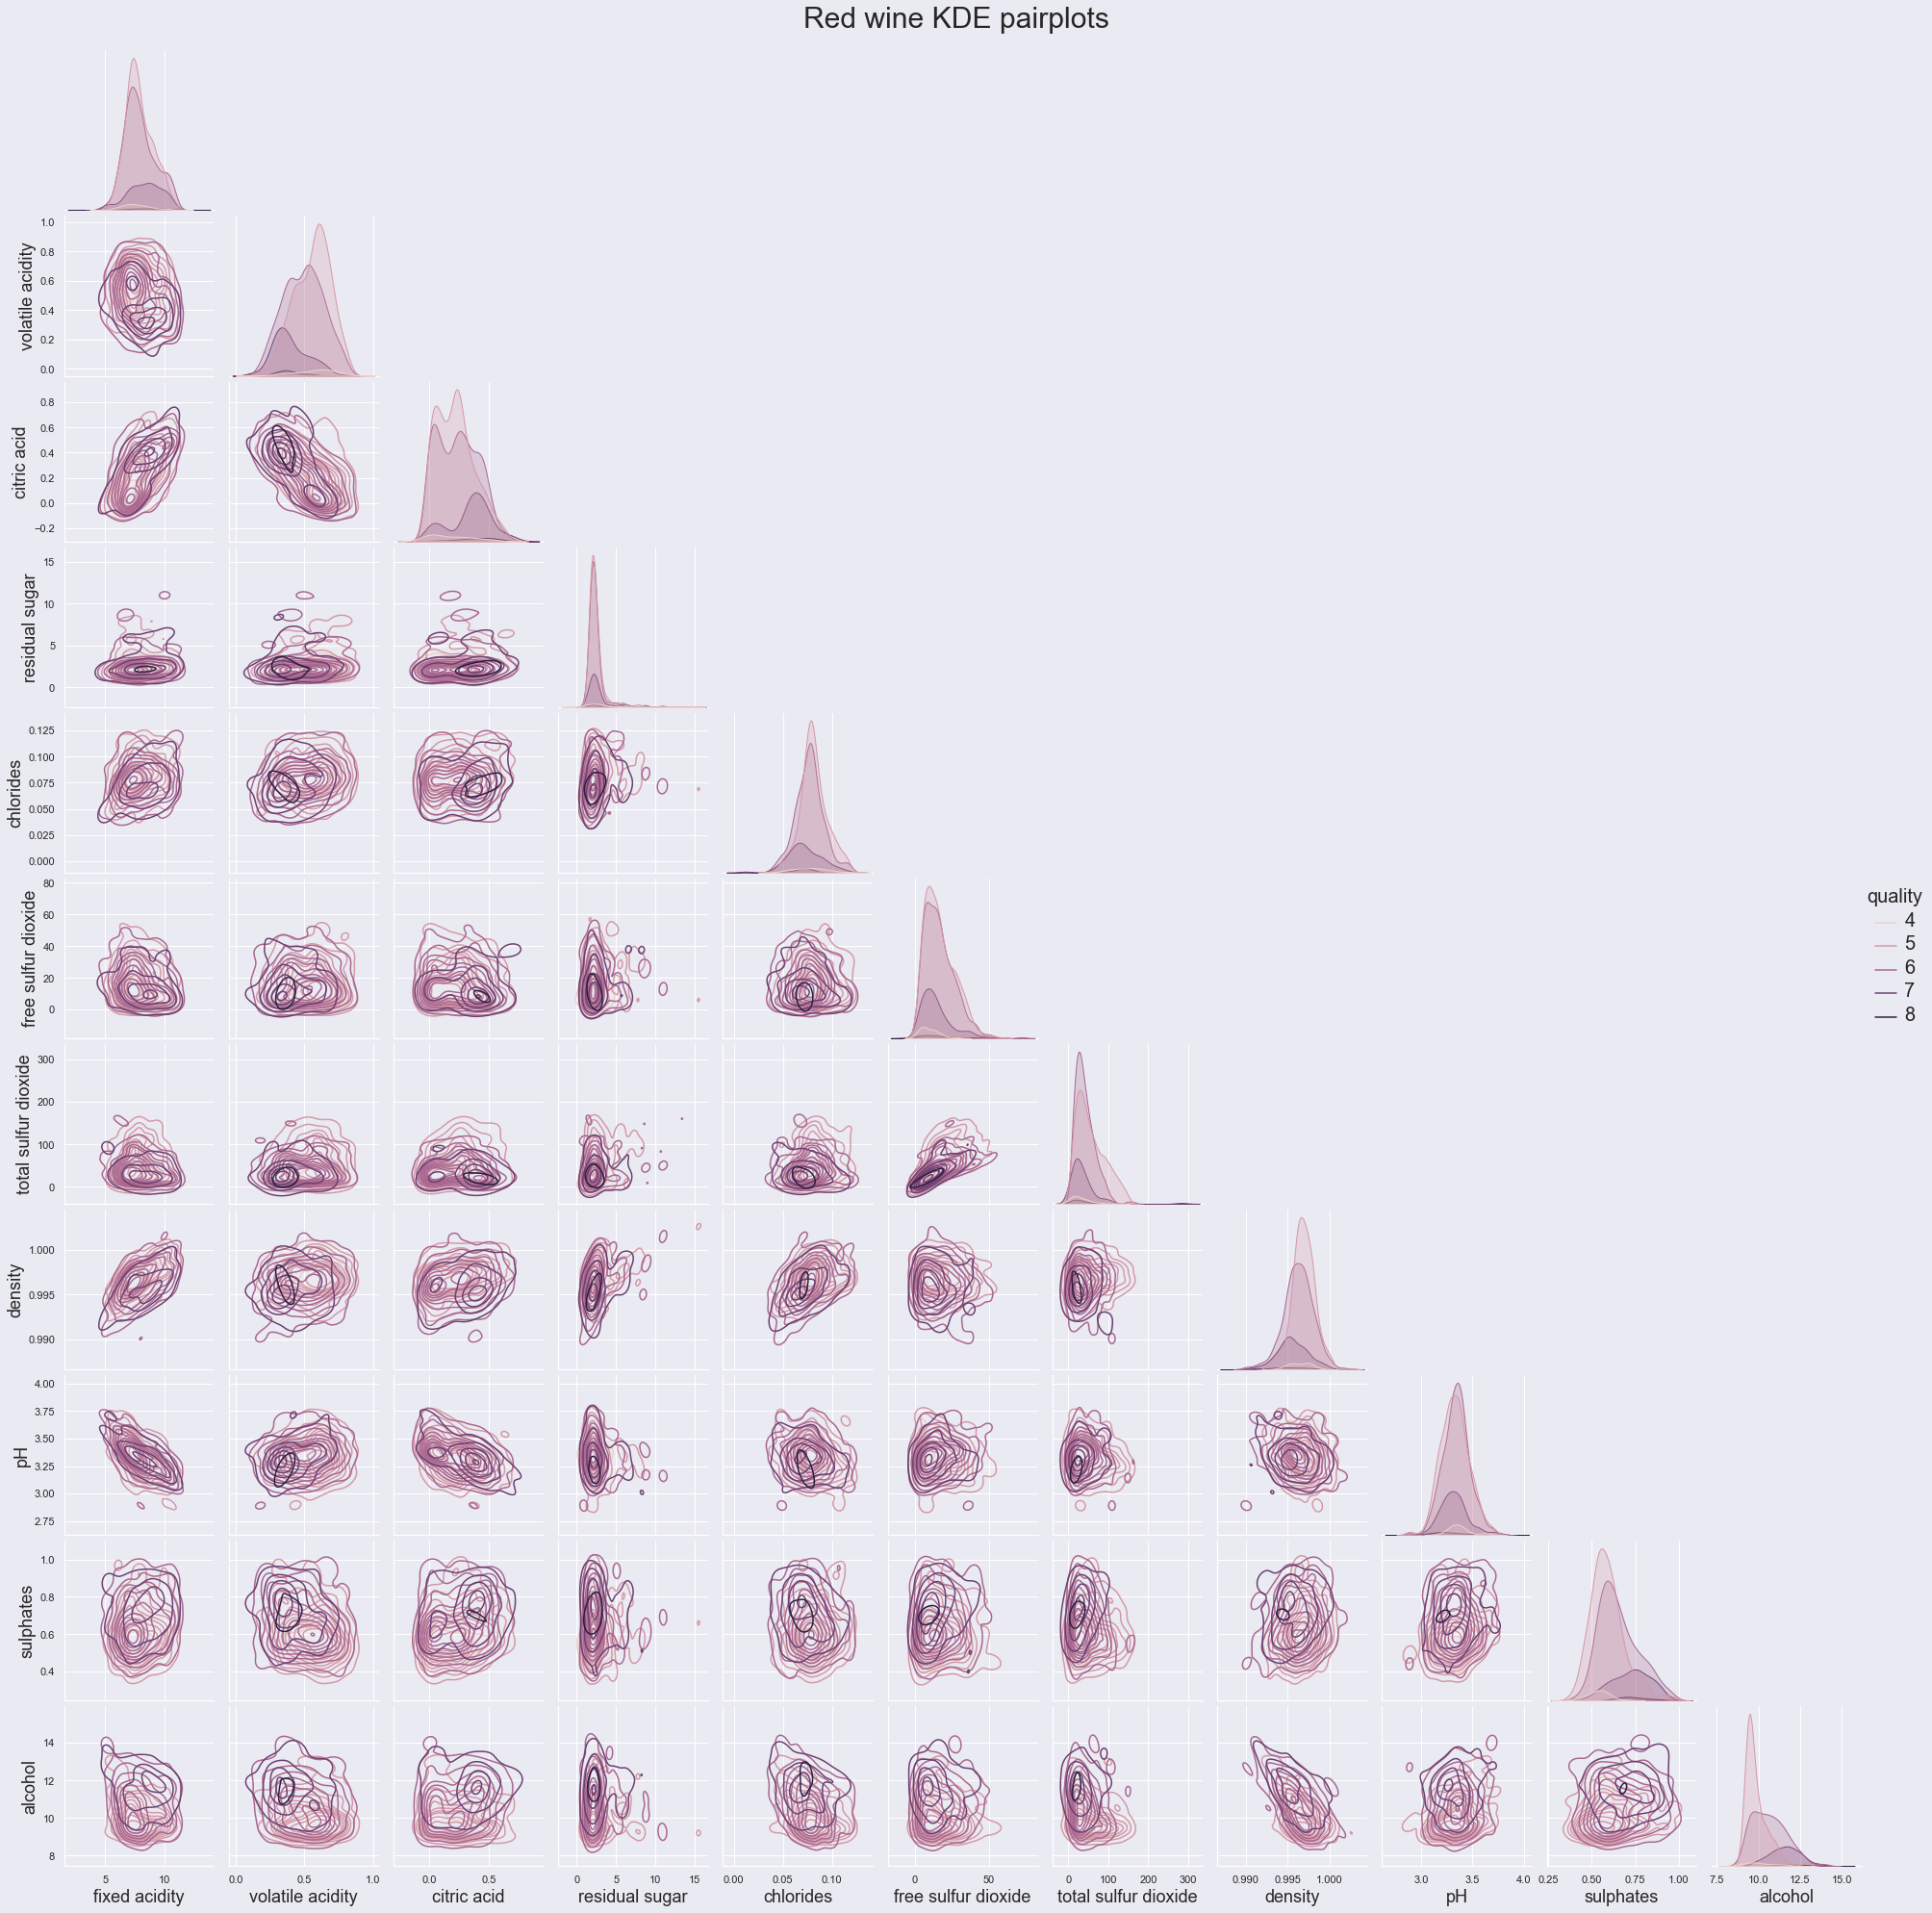

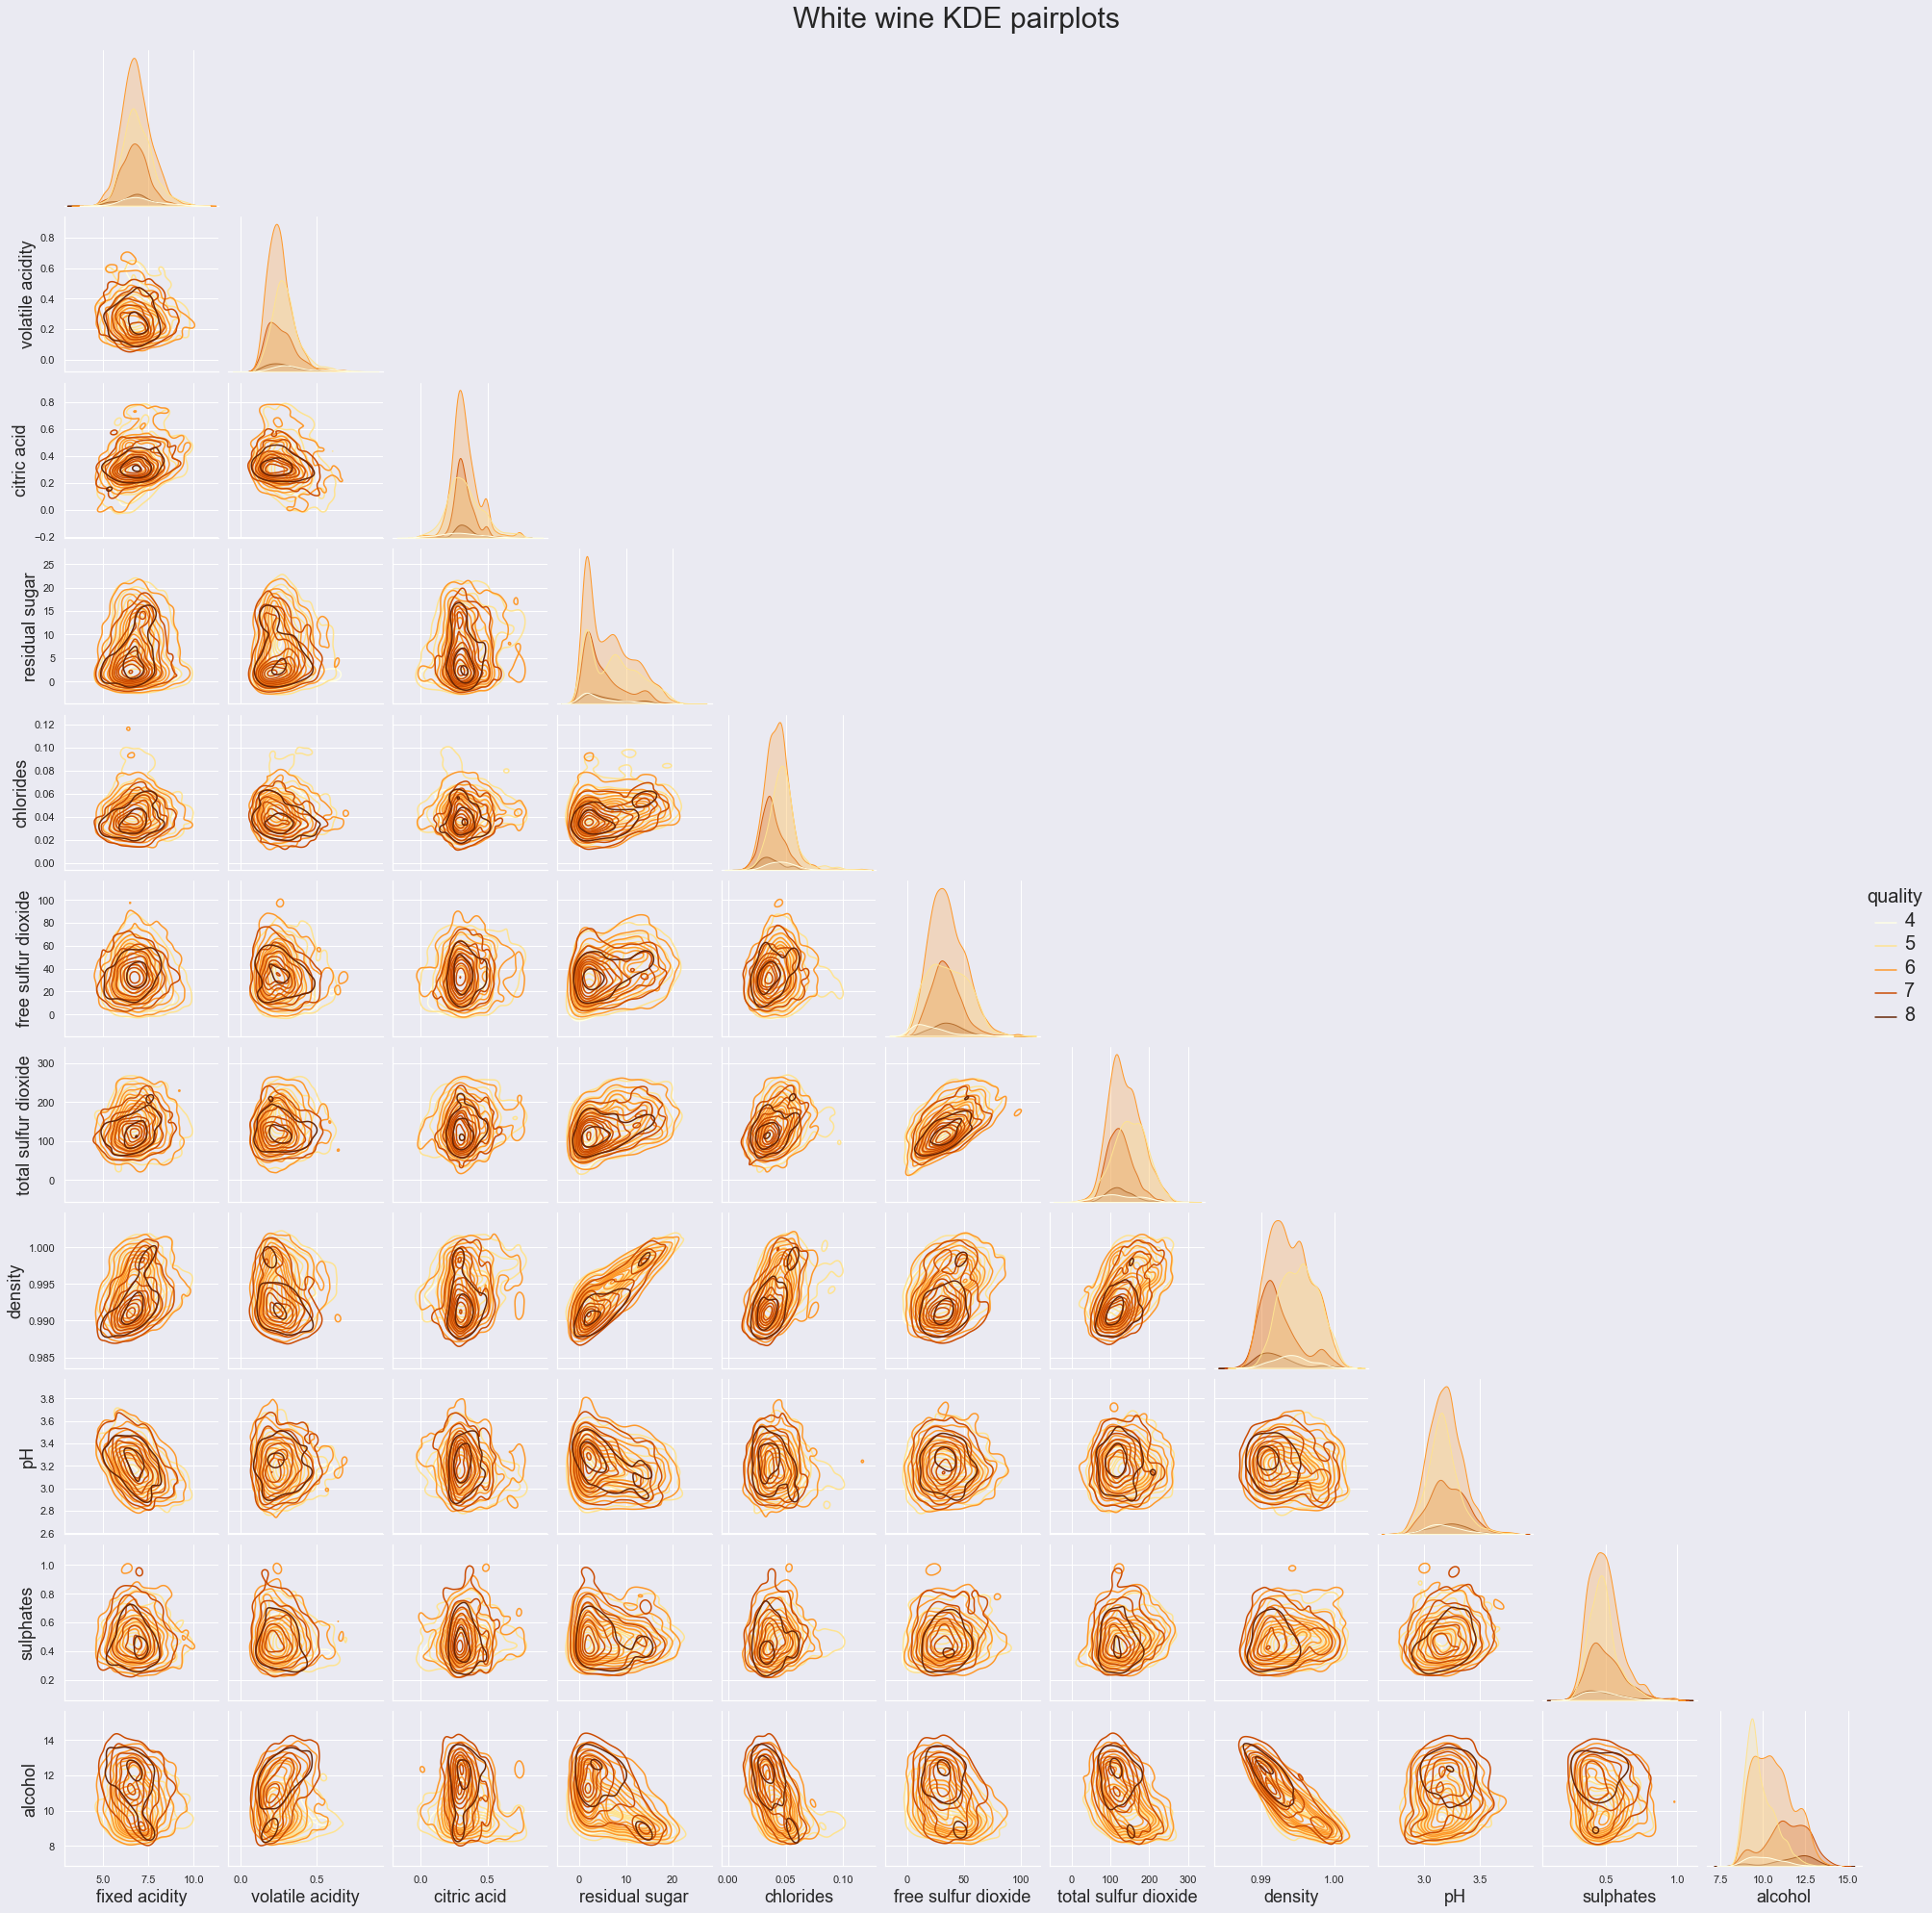

In [17]:
# Create red wine KDE pairplots
sns.set(rc={'figure.facecolor':'#EAEAF2'})
with sns.plotting_context(rc={"axes.labelsize":18}):
    g = sns.pairplot(red_df, kind="kde", hue="quality", corner=True)
    g.fig.suptitle("Red wine KDE pairplots", y=1.01, fontsize=30)
    plt.setp(g._legend.get_title(), fontsize=20)
    plt.setp(g._legend.get_texts(), fontsize=20)

# Create white wine KDE pairplots
with sns.plotting_context(rc={"axes.labelsize":18}):
    g = sns.pairplot(white_df, kind="kde", hue="quality", palette='YlOrBr', corner=True)
    g.fig.suptitle("White wine KDE pairplots", y=1.01, fontsize=30)
    plt.setp(g._legend.get_title(), fontsize=20)
    plt.setp(g._legend.get_texts(), fontsize=20)

* High quality white wines appear to have lower range of citric acid and volatile acidity than high quality red wines, and there is a greater density of high quality red wines at lower concentrations of free sulfur dioxide.

__EDA Summary__

* The target class (wine quality) is imbalanced and appears to follow a normal distribution.

* The largest concentration of a single chemical compound in both wines is total sulfur dioxide (i.e. sulfite, a preservative). This compound is negatively correlated with wine quality, and there is a higher negative correlation for red wine than white wine.

* Density, pH and alcohol content have high positive correlations with quality in both red and white wines. Higher quality white wines have a lower range of citric acid and volatile acidity than high quality red wines.

* The quality of both wines appears to improve as alcohol content increases, and higher concentrations of total sulfur dioxide seem to be more tolerable in high quality white wines than high quality red wines.

## Model Selection:

In my model selection, I intend to make predictions with a base model and then improve upon these predictions by using ensembling methods.

__Base Model: Decision Tree Classifier__

* Decision tree classifiers are a good baseline model because they are capable of multiclass classification, they can be used as a base estimator in random forest and adaboost ensembles, and can generate feature importance from the gini impurity computation at each branch.

__Model 1: Random Forest__

* Random forests are suited for this task because they can improve upon the predictions made from the base decision tree classifier and lower overfitting by bagging (i.e. bootstrap aggregating) whereby we train and aggregate the results of many base models.

__Model 2: Adaboost__

* Adaboost is well suited for this problem because, like decision trees, it is an ensemble method that can improve the predictions made from a base decision tree classifier by boosting, whereby we iteratively improve the predictions made by many weak decision tree learners. 

## Model Training:

__Splitting the dataset__

* First I will split the dataset into training and testing sets. Since the target class (wine quality; an ordinal ranking) follows a normal distribution, I will pass the `stratify` parameter.

* The `stratify` parameter preserves the proportion of samples in each ordinal ranking when splitting the data. We want this because we expect the model to be trained using a normal distribution of wine quality. In other words, we do not want the models to be trained using samples that, by chance, are predominantly of high or low wine quality.

In [18]:
# Select independent and dependent variables for white wine
X_white = white_df.loc[:, ~white_df.columns.isin(["quality"])]
Y_white = white_df['quality']

# Select independent and dependent variables for red wine
X_red = red_df.loc[:, ~red_df.columns.isin(["quality"])]
Y_red = red_df['quality']

# Split the white and red wine dataset into training sets using the balanced training data
WX_train, WX_test, WY_train, WY_test = train_test_split(X_white, Y_white, train_size=0.80, stratify=Y_white)
RX_train, RX_test, RY_train, RY_test = train_test_split(X_red, Y_red, train_size=0.80, stratify=Y_red)

__Target class balancing__

* I will be balancing the target class (`quality`) in the training sets using SMOTE. This will balance the target class by synthetically oversampling minority classes. In SMOTE, minority classes are balanced by generating samples similar to a set number of neighbors using clustering.

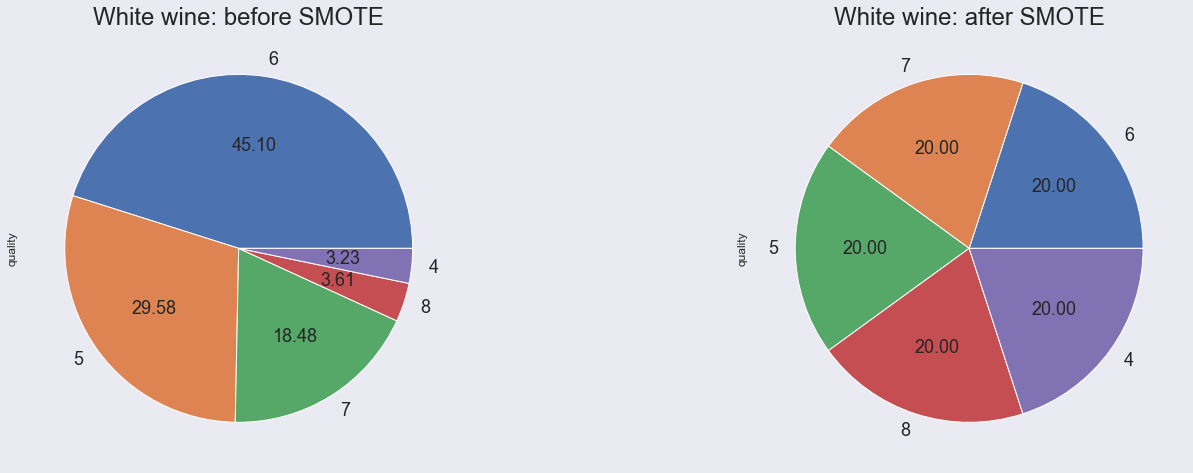

In [19]:
# Copy the original training sets for visualization purposes 
cpy_WY_train = Y_white.copy()

# Balance training data with SMOTE
WX_train, WY_train = SMOTE().fit_resample(WX_train, WY_train)
RX_train, RY_train = SMOTE().fit_resample(RX_train, RY_train)

# Plot the results
fig, ax = plt.subplots(ncols=2)
for training_set, time, ax in zip([cpy_WY_train, WY_train], ["before", "after"], ax):
    training_set.value_counts().plot.pie(autopct="%.2f", ax=ax, textprops={'fontsize': 18})
    ax.set_title(f"White wine: {time} SMOTE", fontdict={'fontsize':24})

__Base model: Decision Tree Classifier__

* Decision trees can overfit, so when training our base model I will select a `max_depth` by plotting model accuracy over increasing tree depths.

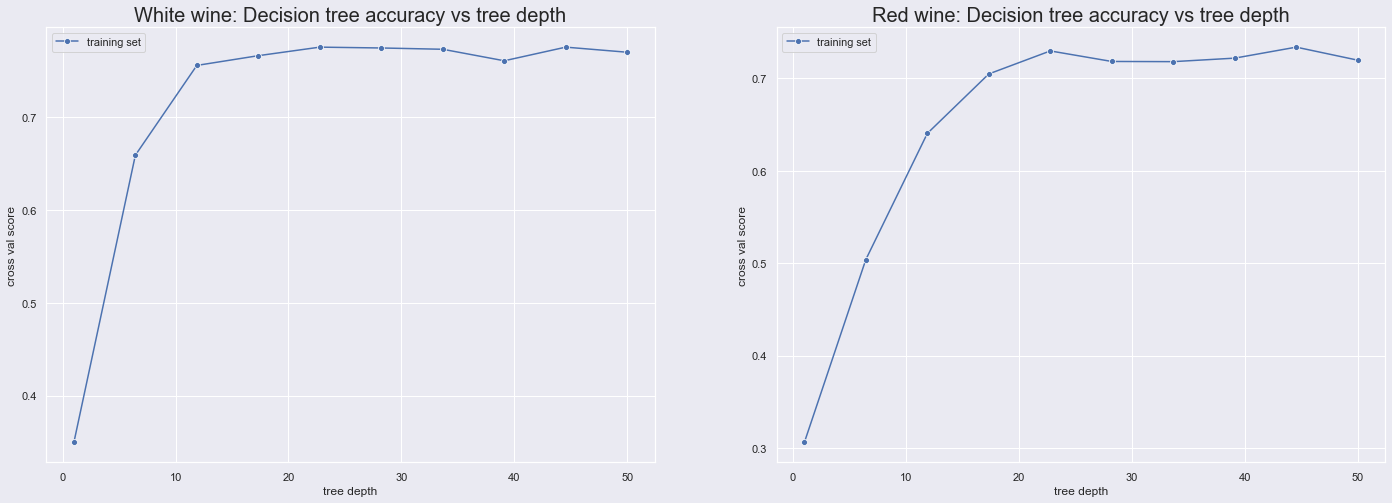

In [20]:
def decision_tree_depth_acc(Xtrain, ytrain):
    '''
    Return mean cross validation scores over a range of tree depths.
    '''
    tree_depth_range = np.linspace(1, 50, 10)
    mean_cv_acc= []
    for depth in tree_depth_range:
        dt = DecisionTreeClassifier(max_depth=depth, max_features='sqrt')
        training_scores = np.round(np.mean(cross_val_score(dt, Xtrain, ytrain)), 4)
        mean_cv_acc.append((depth, training_scores))
    return mean_cv_acc

# Compute mean cv scores for training data and model accuracy for test data over increasing tree_depth
W_dt_scores = decision_tree_depth_acc(RX_train, RY_train)
R_dt_scores= decision_tree_depth_acc(WX_train, WY_train)

# Plot the results
fig, axes = plt.subplots(nrows=1, ncols=2)
for label, tr_scores, ax in zip(["White", "Red"], [W_dt_scores, R_dt_scores], axes):
    X, y = list(list(zip(*tr_scores))[0]), list(list(zip(*tr_scores))[1])
    tr_plot = sns.lineplot(x=X, y=y, marker="o", ax=ax, label="training set")
    ax.set_ylabel("cross val score"); ax.set_xlabel("tree depth")
    ax.set_title(f"{label} wine: Decision tree accuracy vs tree depth", fontdict={'fontsize':20})


* As we increase tree depth, model accuracy improves and approaches a point of diminishing returns after approximately `max_depth=15`, therefore I will train the base model using this hyperparameter.

In [21]:
# Train the base model: a decision tree classifier with tree_depth=15
W_base_model = DecisionTreeClassifier(max_depth=15, max_features='sqrt').fit(WX_train, WY_train)
R_base_model = DecisionTreeClassifier(max_depth=15, max_features='sqrt').fit(RX_train, RY_train)

__Model 1: Random Forest__

* Ensemble methods are generally more resistant to overfitting than individual decision tree classifiers, thus I will attempt to improve on the base model by using an ensemble of base models, i.e. a random forest classifier.

* The hyperparameters tuned in the random forest model will be the number of decision tree classifiers in the forest (`n_estimators`), and the depth of each tree in the forest (`max_depth`). The values for these hyperparameters will be determined by grid search. 

In [22]:
# Create fixed sets of hyperparameters
hyperparameters = { 'n_estimators' : np.linspace(start=100, stop=1000, num=5, dtype=int),
                    'max_depth'    : [5, 10, 20, 40, None] }

# Instantiate a ranom forest model to be used in randomized search
W_estimator = RandomForestClassifier()
R_estimator = RandomForestClassifier()

# Create and fit randomized search objects
W_grid = GridSearchCV(W_estimator, hyperparameters, cv=3, scoring='accuracy').fit(WX_train, WY_train)
R_grid = GridSearchCV(R_estimator, hyperparameters, cv=3, scoring='accuracy').fit(RX_train, RY_train)

# Print the best parameters determinedby the randomized search
print(f"[Random Forest] White Wine params: {W_grid.best_params_}")
print(f"[Random Forest] Red Wine params: {R_grid.best_params_}")

[Random Forest] White Wine params: {'max_depth': None, 'n_estimators': 775}
[Random Forest] Red Wine params: {'max_depth': None, 'n_estimators': 550}


* These values produce higher training accuracy, but may risk overfitting on the training set. I will check for overfitting by plotting cross validation scores as hyperparameters approach the values found by gridsearch.

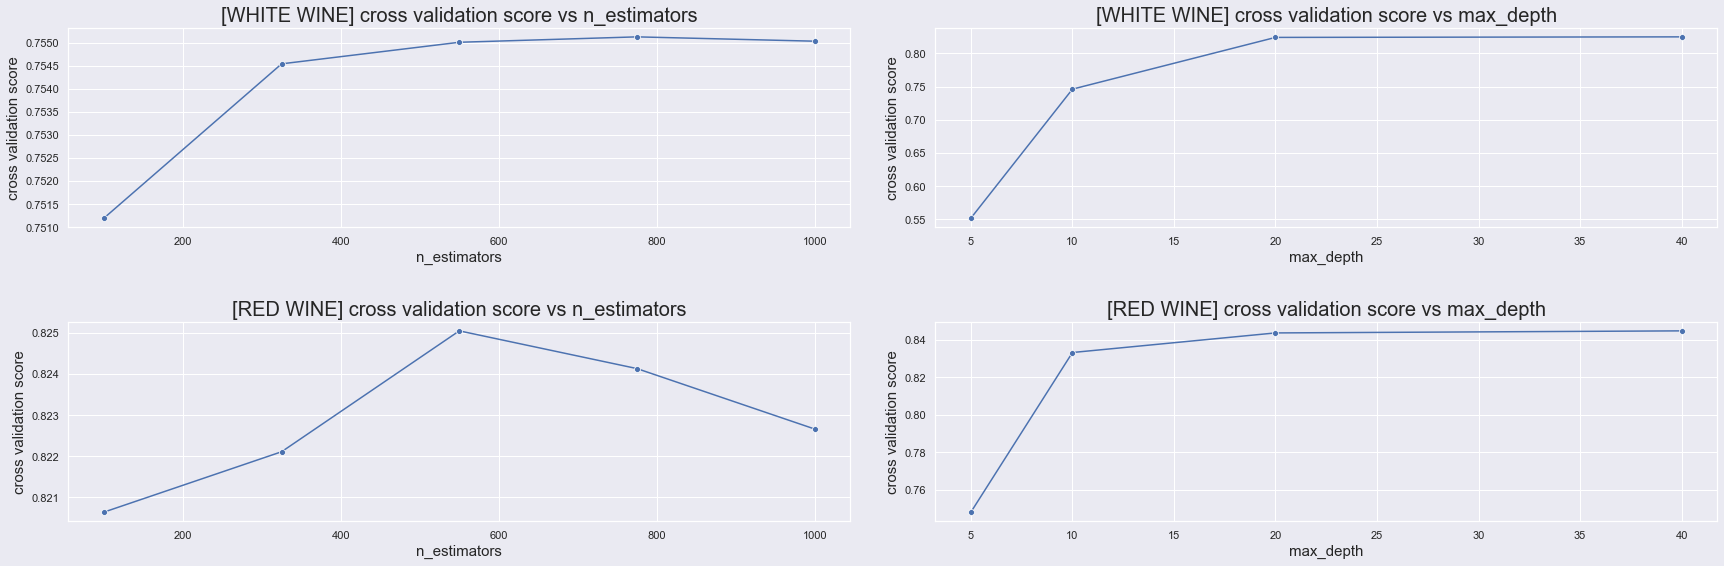

In [45]:
# Get mean cros val scores for each randomized parameter combination
W_scores, R_scores = list(W_grid.cv_results_['mean_test_score']), list(R_grid.cv_results_['mean_test_score'])

# Get paramaters checked during grid searc
W_params = W_grid.cv_results_['params']
R_params = R_grid.cv_results_['params']

# Zip hyperparameters with their scores
W_scores = zip(W_scores, [t['n_estimators'] for t in W_params], [t['max_depth'] for t in W_params])
R_scores = zip(R_scores, [t['n_estimators'] for t in R_params], [t['max_depth'] for t in R_params])

# Plot cross validation score with the corresponding hyperparameters
fig, axes = plt.subplots(nrows=2, ncols=2)
for s, l, ax in zip([W_scores, R_scores], ["WHITE", "RED"], axes):
    iters = [a for a in s]
    scores, n_estimators, max_depth = [s[0] for s in iters], [s[1] for s in iters], [s[2] for s in iters]
    sns.lineplot(x=n_estimators, y=scores, marker="o", err_style=None, ax=ax[0])
    sns.lineplot(x=max_depth, y=scores, marker="o", err_style=None, ax=ax[1])
    ax[0].set_ylabel("cross validation score", fontsize=15); ax[0].set_xlabel("n_estimators", fontsize=15)
    ax[1].set_ylabel("cross validation score", fontsize=15); ax[1].set_xlabel("max_depth", fontsize=15)
    ax[0].set_title(f"[{l} WINE] cross validation score vs n_estimators", fontsize=20)
    ax[1].set_title(f"[{l} WINE] cross validation score vs max_depth", fontsize=20)
fig.tight_layout(pad=1.0, w_pad=3.0, h_pad=3.0);

* In an effort to lower model complexity and reduce overfitting, based on these plots I will select `max_depth=15` and `n_estimators=500` to train the random forest classifiers with both red wine and white wine datasets. 

In [46]:
# Train the random forest classifiers with n_estimators=500 and max_depth=15
W_forest_model = RandomForestClassifier(n_estimators=500, max_depth=15, max_features='sqrt').fit(WX_train, WY_train)
R_forest_model = RandomForestClassifier(n_estimators=500, max_depth=15, max_features='sqrt').fit(RX_train, RY_train)

__Model 2: Adaboost__

* Adaboost improves the performance of a set of weak learners by iteratively training each weak learner using a weight vector that is updated based upon the misclassification error of prior weak learners in the series.

* In this model, I will use adaboost to boost the performance of our base model: the decision tree classifier. In class, we boosted "stumps" with depth of 1 or 3. In this project, I will use the base model with a slightly larger depth of 5; a "sapling", if you will.

In [47]:
# Train adaboost classifiers using the base model as the base estimator
dt = DecisionTreeClassifier(max_depth=5, max_features='sqrt')
W_adaboost_model = AdaBoostClassifier(base_estimator=dt, n_estimators=500, algorithm='SAMME').fit(WX_train, WY_train)
R_adaboost_model = AdaBoostClassifier(base_estimator=dt, n_estimators=500, algorithm='SAMME').fit(RX_train, RY_train)

__Feature Importance__

* With all models trained, I will now collect and plot feature importances from each trained model (decision tree, random forest, adaboost). Each feature importance score is computed using gini importance which is the mean decrease of impurity for a given feature. 

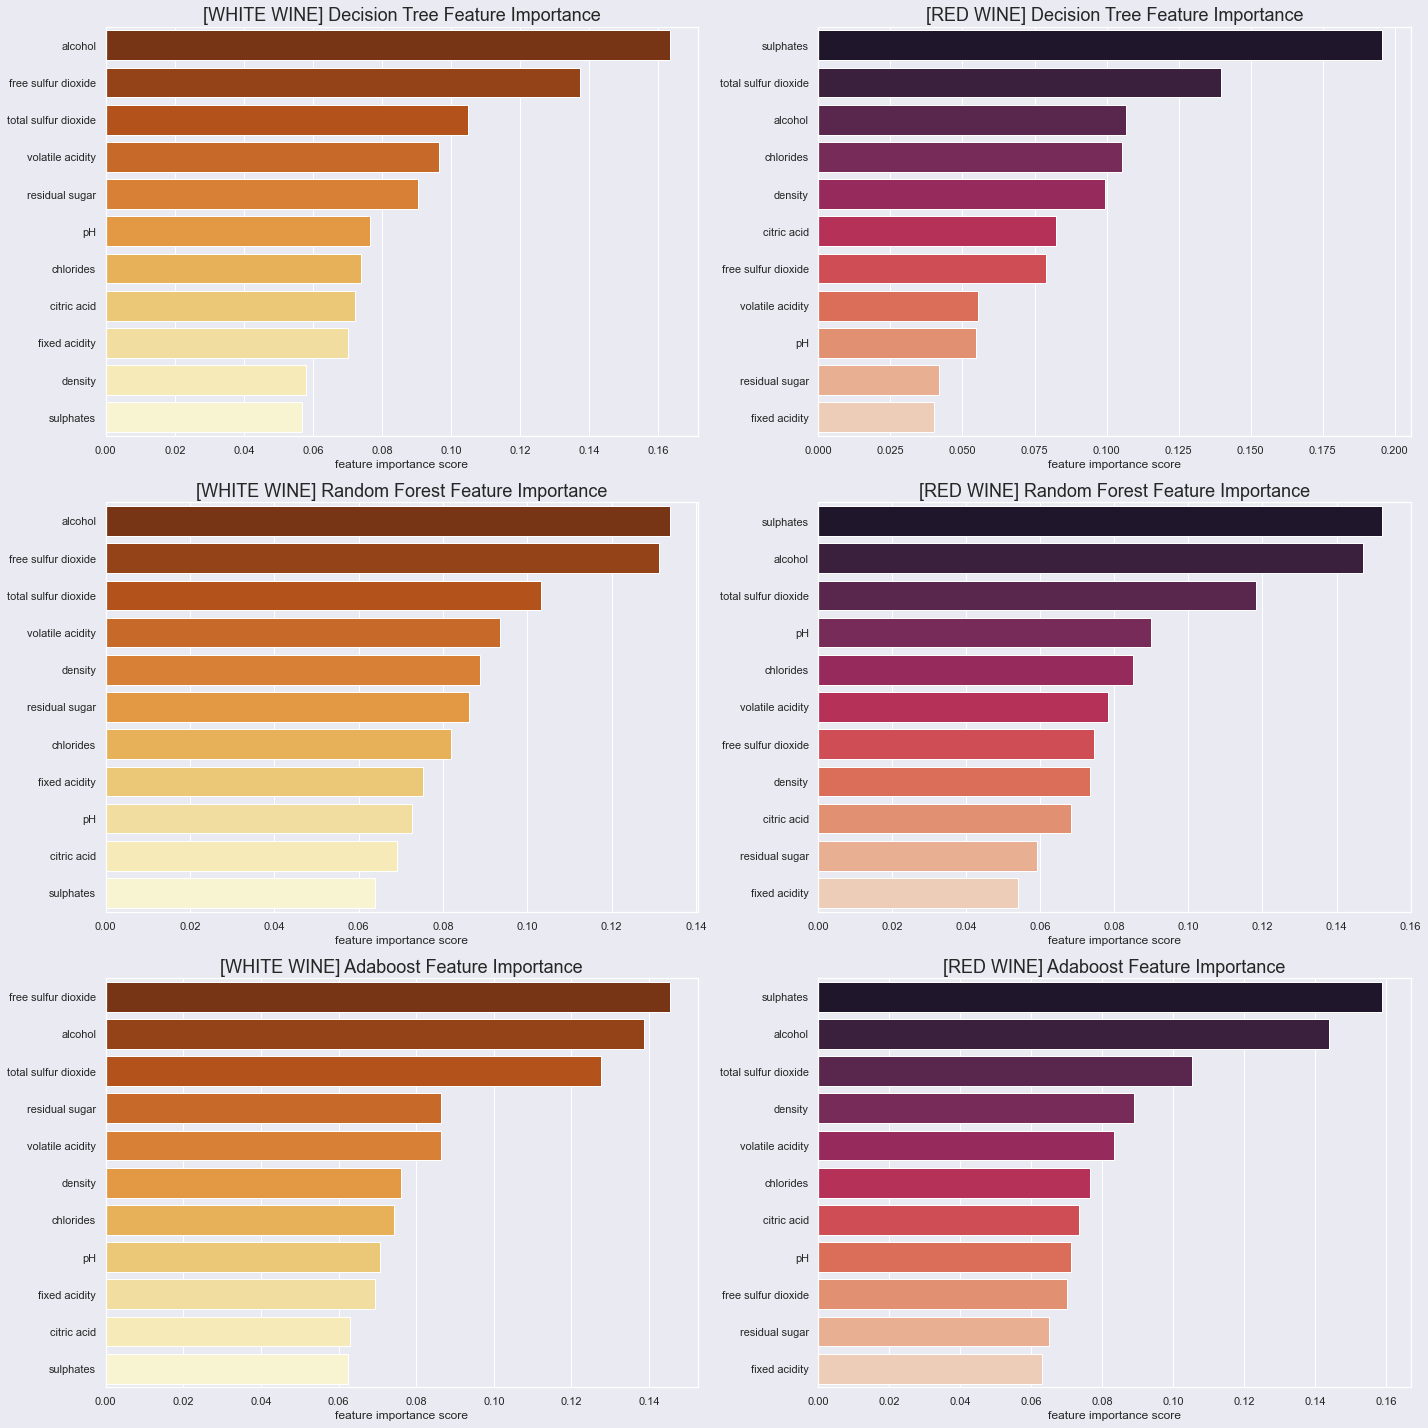

In [48]:
# Collect all the trained models for both red and white wine datasets
trained_models = np.array([[W_base_model,     R_base_model], 
                           [W_forest_model,   R_forest_model], 
                           [W_adaboost_model, R_adaboost_model]])

cm_labels = ["Decision Tree", "Random Forest", "Adaboost"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for models, l, ax in zip(trained_models, cm_labels, axes):
    W_features = get_feature_importance(WX_train, models[0])
    R_features = get_feature_importance(RX_train, models[1])
    w = sns.barplot(x=[t[1] for t in W_features], y=[t[0] for t in W_features], palette='YlOrBr_r', ax=ax[0])
    r = sns.barplot(x=[t[1] for t in R_features], y=[t[0] for t in R_features], palette='rocket', ax=ax[1])
    ax[0].set_xlabel("feature importance score"); ax[1].set_xlabel("feature importance score")
    ax[0].set_title(f"[WHITE WINE] {l} Feature Importance", fontsize=18)
    ax[1].set_title(f"[RED WINE] {l} Feature Importance", fontsize=18)
fig.tight_layout();

* Alcohol content has a very high feature importance across all models and for both red and white wine datasets. This is consistent with our EDA observations which identified a high positive correlation between alcohol and quality.

* Density seems to be highly important for white wines; moreso than red. The models differed on highly important features for red wine, but sulphates and total sulphur dioxide seem to be consistently high, and this is consistent with our EDA observations which identified a large negative correlation between total sulphur dioxide and red wine quality.

## Results and Analysis

__Confusion matrices__

* Compute and plot confusion matrices for decision trees, random forest, and adaboost models trained with red or white wine datasets in order to visualize the number of true positive, false positive, true negative, and false negative wine quality predictions.

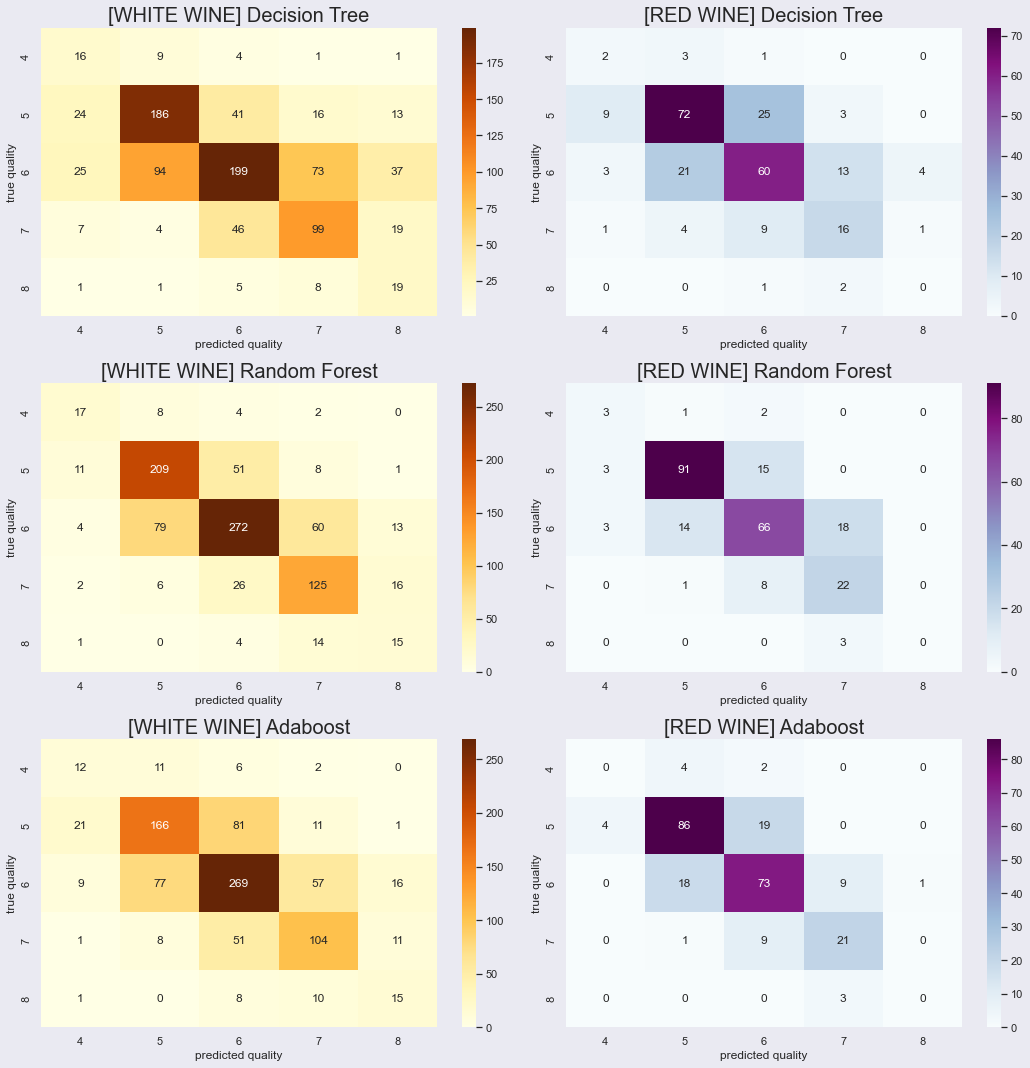

In [49]:
# Compute confusion matrices
cms = []
for W_model, R_model in trained_models:
    W_cm = get_confusion_matrix(WX_test, WY_test, W_model)
    R_cm = get_confusion_matrix(RX_test, RY_test, R_model)
    cms.append([W_cm, R_cm])

# Plot confusion matrices for each model
feature_axes = [4, 5, 6, 7, 8]
cm_labels = ["Decision Tree", "Random Forest", "Adaboost"]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
for cm, l, ax in zip(cms, cm_labels, axes):
    w = sns.heatmap(cm[0], annot=True, xticklabels=feature_axes, yticklabels=feature_axes, 
                    fmt='g', cmap='YlOrBr', ax=ax[0])
    r = sns.heatmap(cm[1], annot=True, xticklabels=feature_axes, yticklabels=feature_axes, 
                    fmt='g', cmap='BuPu', ax=ax[1])
    ax[0].set_title(label=f"[WHITE WINE] {l}", fontdict={'fontsize':20})
    ax[1].set_title(label=f"[RED WINE] {l}", fontdict={'fontsize':20})
    w.set(xlabel="predicted quality", ylabel="true quality")
    r.set(xlabel="predicted quality", ylabel="true quality")
fig.tight_layout();

__Confusion matrix analysis__

* The dark shaded diagonal regions of each matrix indicate the number of true positive predictions. For both wines, all models made the most true positive predictions for the majority classes, which is quality=6 for white wine and quality=5 and quality=6 for red wine. This may simply be due to the lack of minority class samples in the testing dataset. 

* The amount of false negatives and false positives for both wines is most abundant for the majority classes as well, and these can be seen as slightly faded regions surrounding the darker diagonal true positives. 

* This indicates that the models are fairly good at predicting poor or excellent wines (i.e. quality 4 and 8) from average wines (i.e. quality 5 - 7), and fairly bad at predicting average wines from above average wines, e.g. correctly predicting a quality=7 from a quality=6 wine.

__Receiver operating characteristic (ROC) curves__

* Next I will plot ROC curves for each model which will allow us to compare model performance by plotting the rate of true positive classifications versus the rate of false positive classifications generated by each model at different classification thresholds. 

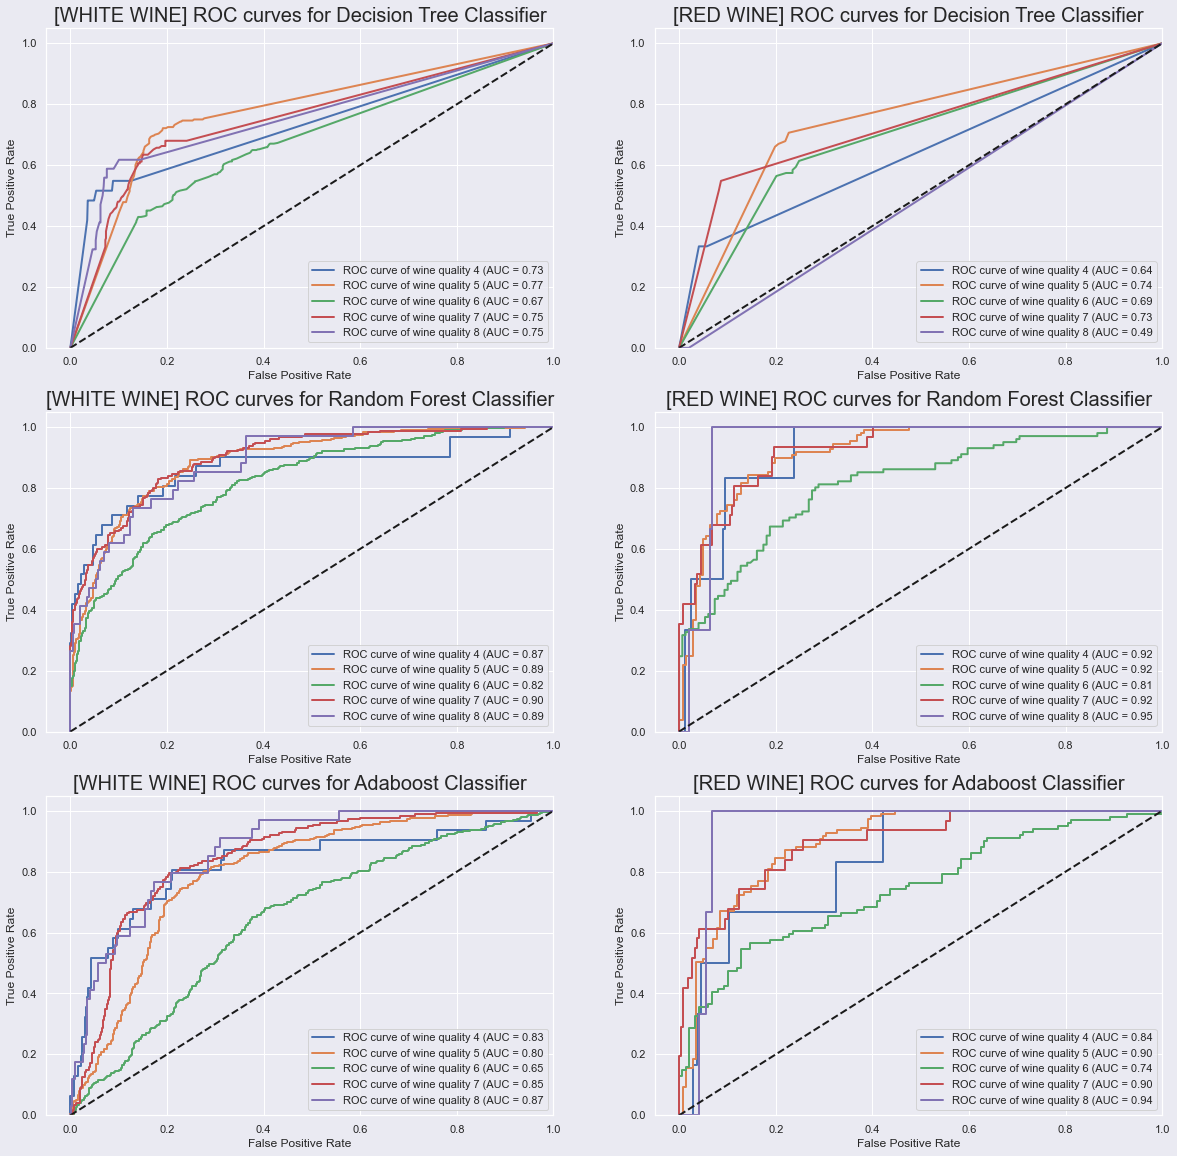

In [50]:
# Compute AUC and plot ROC curves from the predictions by each model
model_labels = ["Decision Tree", "Random Forest", "Adaboost"]
feature_axes = [4, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
for models, ml, ax in zip(trained_models, model_labels, axes):
    plot_multiclass_ROC(WX_test, WY_test, models[0], class_labels=feature_axes, 
                        plot_labels=["WHITE", ml], axis=ax[0])
    plot_multiclass_ROC(RX_test, RY_test, models[1], class_labels=feature_axes, 
                        plot_labels=["RED", ml], axis=ax[1])

__ROC curve analysis__

* The ROC curves indicate that the random forest (second row) and adaboost (third row) generally improve upon the performance of the base decision tree classifier (first row). 

* The ROC curves are quantified as area under each curve (AUC), and the AUC values support both ensemble methods being improvements to the base model. If we compare the AUC values for each ensemble method, it appears the random forest outperforms the adaboost model. 

* A big flaw of the adaboost model is the AUC for wine quality=6 (green ROC curve), which is quite low. This is reflected in the adaboost confusion matrices where, at quality=6, there are approximately double the amount of false positives compared to random forest.

__F1 Scores__

* Lastly, I will evaluate the performance of each model by computing macro and weighted average f1-scores. The F1 score is ideal for evaluating this data because it is highly imbalanced. Recall F1 score is computed as so:

$$ F_1 = \dfrac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}$$

$$\text{precision} = \dfrac{TP}{TP + FP}$$
$$\text{recall} = \dfrac{TP}{TP + FN}$$

* Since there are an abundance of average quality wines (i.e. around quality=5 or quality=6), accuracy would be a very bad metric. The model could simply pick an average quality every time and have a high accuracy score due to the abundance of average quality wines.

* F1 score is a better metric because it takes into consideration precision (i.e. percentage of correct positive predictions for a class among all positive predictions for a class) and recall (i.e. percentage of correct positive predictions for a class extracted from negative predictions). 

* The weighted and macro average F1 scores for all wine quality predictions in each dataset and each learning algorithm will be computed to compare model performance. Macro F1 average is simply the average F1 score, while weighted takes into account the support for each class.

In [51]:
# Initialize multiindex to collect F1 scores for each dataset and model
f1_df = pd.DataFrame(
    np.random.randn(2, 6), 
    index=[['F1 score (macro avg)', 'F1 score (weighted avg)']],
    columns=[["Decision Tree", "Decision Tree", "Random Forest", "Random Forest", "Adaboost", "Adaboost"],
             ["Red Wine", "White Wine", "Red Wine", "White Wine", "Red Wine", "White Wine"]])

# Populate multiindex with macro avg and weighted avg F1 scores
for models, model_type in zip(trained_models, ["Decision Tree", "Random Forest", "Adaboost"]): 
    W_f1_macro_avg, W_f1_weighted_avg = get_F1_avgs(WX_test, WY_test, models[0])
    f1_df.loc['F1 score (macro avg)', (model_type, 'White Wine')] = W_f1_macro_avg
    f1_df.loc['F1 score (weighted avg)', (model_type, 'White Wine')] = W_f1_weighted_avg
    R_f1_macro_avg, R_f1_weighted_avg = get_F1_avgs(RX_test, RY_test, models[1])
    f1_df.loc['F1 score (macro avg)', (model_type, 'Red Wine')] = R_f1_macro_avg
    f1_df.loc['F1 score (weighted avg)', (model_type, 'Red Wine')] = R_f1_weighted_avg
display(f1_df)

Decision Tree            Random Forest             \
                             Red Wine White Wine      Red Wine White Wine   
F1 score (macro avg)         0.396183   0.469492      0.504937   0.591429   
F1 score (weighted avg)      0.612111   0.559344      0.728450   0.675648   

                         Adaboost             
                         Red Wine White Wine  
F1 score (macro avg)     0.432185   0.507948  
F1 score (weighted avg)  0.714512   0.600444

__F1 scores analysis__

* The weighted F1 scores support the ROC and AUC in that, both ensemble methods improve upon the performance of the base decision tree classifier.

* The ROC curves and AUC scores indicated that the random forest models performed better overall than the adaboost models, and the weighted F1 scores support this for both the red wine and white wine datasets. 

## Conclusions and Discussion

__Summary of results__

* Both random forest and adaboost ensemble methods improved the classification performance of the base decision tree classifier.

* Overall, random forest performed slightly better than adaboost and this is supported by AUC and weighted F1 scores.

* Each classifier had difficulty differentiating wines of average quality (i.e. quality=5 to 7), however this could be due to there being simply a lack of testing samples that are of poor (quality < 4) or excellent (quality > 7) quality in the test dataset.

* When buying wine sourced from vinho verde (the source of wines in this dataset), consider higher alcohol content since this feature was rated highly important by all models for both white and red wine.

__Discussion and improvements__

The most difficult challenges that I encountered while working with this dataset were the class imbalance in the target class, the abundance of outliers in certain features (e.g. residual sugar), and the lack of red wine data samples. The class imbalance was expected due to the nature of the target class; there will always be fewer excellent quality wines. However, this made it difficult to train models because there were far fewer examples of poor or excellent quality wines. This issue was compounded after splitting the dataset with a stratified 80/20 split, which made the test set quite small (see below):

In [52]:
# Print the size of the red wine test set
print(f"Red wine test set size: {len(RX_test)}")
print("Red wine total quality=8 samples: {}".format(len(df[(df["type"]=="Red") & (df["quality"] == 8)])))

Red wine test set size: 250
Red wine total quality=8 samples: 14



Unfortunately, this is a difficult problem to address. Other than simply collecting more minority class data, especially for the red wine dataset, perhaps very high class weights could be applied to these minority classes in an effort to very heavily penalize when they are missclassified. Given the large class imbalances, it would be ideal to compare a variety of additional class balance techniques, such as random undersampling, applying class weights, and SMOTE, and then select the technique that creates the largest improvement on model performance.

One last suggestion to possibly improve model performance would be approaching the problem from a slightly different angle. This project treated the target class `quality` as an ordinal class; that is, given a feature vector for a wine, we classify its quality into an ordinal quality ranking. Perhaps the models would perform better by simplifying the problem into a binary classification task, wherein the target class would be simply: "pass" if wine quality is above 5, and "fail" if wine quality is below 5. This could benefit wine producers by still allowing them to screen the quality of their wine quickly and efficiently. After pre-screening using machine learning algorithms, expert wine tasters could continue to taste each wine and rank them into quality rankings of higher granularity; that is, from quality rankings 5 to 10.